# How do art themes change as social movements emerge?

LSE DS105A - Data for Data Science (2024/25)

**Date**: 20/01/24

**Authors**: Amelia Dunn

**Objective**:🌟 Visualise how art themes and emergance of social movements correlate

In [1]:
import os
import json
import requests
import glob

import pandas as pd

from dotenv import load_dotenv
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.display import Image

import sqlite3
from sqlalchemy import create_engine, text

/tmp/ipykernel_383/3658656986.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=combined_df, x='Year', y='ThemeCount', hue='Topics', ci=None, marker='o', label='Art Themes')
/tmp/ipykernel_383/3658656986.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


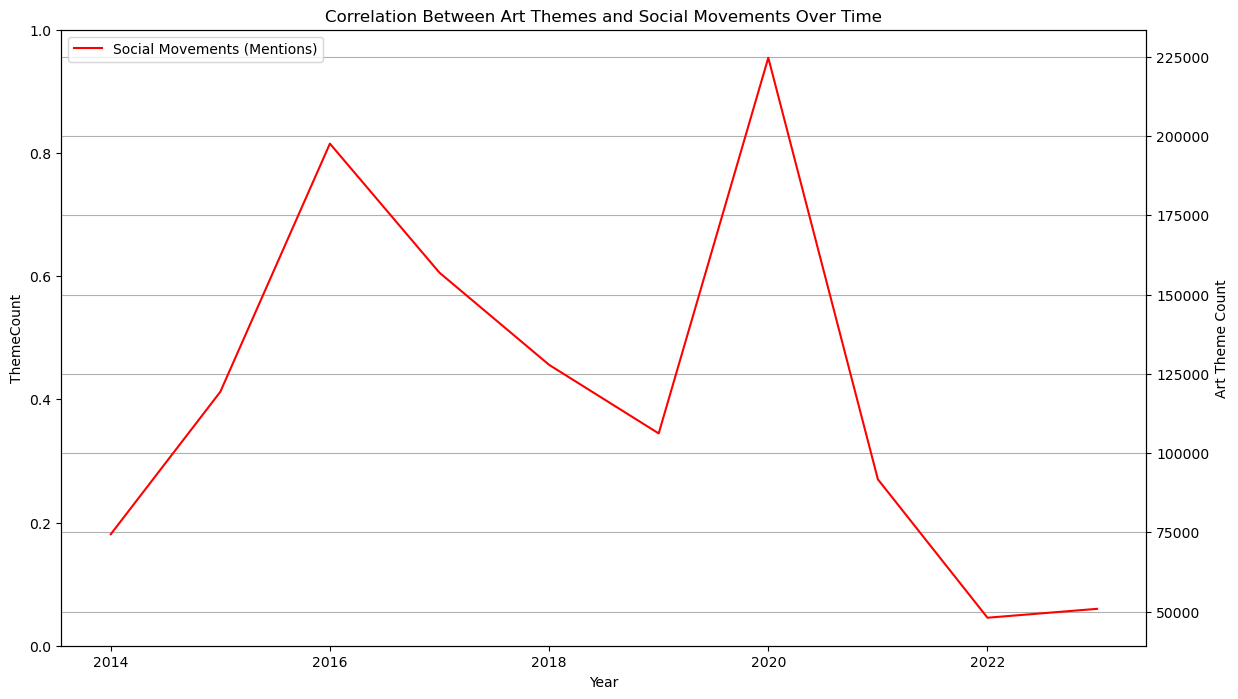

Correlation between art themes and social movement mentions: nan
Empty DataFrame
Columns: [Year, Topics, ThemeCount, TotalMentions, AvgTone]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           0 non-null      int64  
 1   Topics         0 non-null      object 
 2   ThemeCount     0 non-null      int64  
 3   TotalMentions  0 non-null      int64  
 4   AvgTone        0 non-null      float64
dtypes: float64(1), int64(3), object(1)
memory usage: 132.0+ bytes
None
ThemeCount       0
TotalMentions    0
dtype: int64


In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Connect to SQLite database
db_path = "../data_amelia/processed/social_movements.db"  
conn = sqlite3.connect(db_path)

# Step 2: Query Smithsonian data
query_smithsonian = """
SELECT 
    ProductionYear AS Year, 
    Topics 
FROM 
    SmithsonianArtworks 
WHERE 
    ProductionYear >= 1900
"""
smithsonian_df = pd.read_sql_query(query_smithsonian, conn)

# Explode the topics into separate rows
smithsonian_df['Topics'] = smithsonian_df['Topics'].str.split(', ')
smithsonian_exploded = smithsonian_df.explode('Topics')

# Count themes by year
smithsonian_trends = (
    smithsonian_exploded.groupby(['Year', 'Topics'])
    .size()
    .reset_index(name='ThemeCount')
)

# Step 3: Query GDELT data
query_gdelt = """
SELECT 
    strftime('%Y', Date) AS Year, 
    SUM(NumMentions) AS TotalMentions, 
    AVG(AvgTone) AS AvgTone 
FROM 
    SocialMovements 
WHERE 
    Date >= '1900-01-01'
GROUP BY 
    Year
"""
gdelt_df = pd.read_sql_query(query_gdelt, conn)


# Convert Year to integer
gdelt_df['Year'] = gdelt_df['Year'].astype(int)
gdelt_df = gdelt_df[gdelt_df['Year'] >= 2014]

# Step 4: Merge the two datasets
combined_df = pd.merge(smithsonian_trends, gdelt_df, on='Year', how='inner')

# Step 5: Visualization
plt.figure(figsize=(14, 8))

# Line plot for theme counts
sns.lineplot(data=combined_df, x='Year', y='ThemeCount', hue='Topics', ci=None, marker='o', label='Art Themes')

# Secondary axis for social movement mentions
ax2 = plt.gca().twinx()
sns.lineplot(
    data=gdelt_df, x='Year', y='TotalMentions', color='red', ci=None, ax=ax2, label='Social Movements (Mentions)'
)

# Labels and legend
plt.title("Correlation Between Art Themes and Social Movements Over Time")
plt.xlabel("Year")
ax2.set_ylabel("Social Movements (Mentions)")
plt.ylabel("Art Theme Count")
plt.legend(loc="upper left")
plt.grid()
plt.show()

# Step 6: Analyze correlation
#correlation_df = combined_df.groupby('Year').agg({'ThemeCount': 'sum', 'TotalMentions': 'sum'})
#correlation = correlation_df.corr().loc['ThemeCount', 'TotalMentions']
#print(f"Correlation between art themes and social movement mentions: {correlation:.2f}")

correlation_df = combined_df[['ThemeCount', 'TotalMentions']]
correlation = correlation_df.corr().loc['ThemeCount', 'TotalMentions']
print(f"Correlation between art themes and social movement mentions: {correlation:.2f}")


print(combined_df.head())
print(combined_df.info())
print(correlation_df.isnull().sum())


# Close the database connection
conn.close()



In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Connect to SQLite database
conn = sqlite3.connect('../data_amelia/processed/social_movements.db')

# Define social movement terms
social_movements = {
    'immigration': ['immigration', 'migrant', 'refugee'],
    'black_movements': ['black lives matter', 'racial equality', 'civil rights'],
    'climate_change': ['climate change', 'global warming', 'environmental justice']
}

# Combine all terms into a single list for querying
all_terms = [term for terms in social_movements.values() for term in terms]

# Load GDELT data with year extraction
gdelt_query = f"""
SELECT strftime('%Y', date) AS Year, 
       COUNT(CASE WHEN {' OR '.join([f"LOWER(RelevantCountry) LIKE '%{term}%'" for term in social_movements['immigration']])} THEN 1 END) as ImmigrationMentions,
       COUNT(CASE WHEN {' OR '.join([f"LOWER(RelevantCountry) LIKE '%{term}%'" for term in social_movements['black_movements']])} THEN 1 END) as BlackMentions,
       COUNT(CASE WHEN {' OR '.join([f"LOWER(RelevantCountry) LIKE '%{term}%'" for term in social_movements['climate_change']])} THEN 1 END) as ClimateMentions
FROM SocialMovements 
GROUP BY Year
"""
gdelt_data = pd.read_sql_query(gdelt_query, conn)

# Load Smithsonian data with year extraction
smithsonian_query = """
SELECT strftime('%Y', ProductionYear) AS Year, Topics
FROM SmithsonianArtworks
WHERE ProductionYear >= '2014'
"""
smithsonian_data = pd.read_sql_query(smithsonian_query, conn)

# Process Smithsonian data
smithsonian_data['Topics'] = smithsonian_data['Topics'].fillna('').str.lower()
for category, terms in social_movements.items():
    smithsonian_data[category + '_mentions'] = smithsonian_data['Topics'].apply(
        lambda x: sum(x.count(term) for term in terms)
    )

smithsonian_grouped = smithsonian_data.groupby('Year').sum().reset_index()

# Merge GDELT and Smithsonian data
merged_data = pd.merge(gdelt_data, smithsonian_grouped, on='Year', how='inner')

# Correlation analysis
correlations = {}
for movement in social_movements.keys():
    gdelt_col = f"{movement.capitalize()}Mentions"
    smithsonian_col = f"{movement}_mentions"
    correlations[movement] = merged_data[gdelt_col].corr(merged_data[smithsonian_col])
    print(f"Correlation between {movement.replace('_', ' ')} mentions and art themes: {correlations[movement]:.2f}")

# Plot data
plt.figure(figsize=(12, 8))

for i, movement in enumerate(social_movements.keys(), start=1):
    plt.subplot(3, 1, i)
    plt.plot(merged_data['Year'], merged_data[f"{movement.capitalize()}Mentions"], label=f'{movement.replace("_", " ").title()} (GDELT)', marker='o')
    plt.plot(merged_data['Year'], merged_data[f"{movement}_mentions"], label=f'{movement.replace("_", " ").title()} (Smithsonian)', marker='x')
    plt.title(f'{movement.replace("_", " ").title()} Mentions Over Time')
    plt.xlabel('Year')
    plt.ylabel('Mentions')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Save merged data for further inspection
merged_data.to_csv('merged_social_movements_art.csv', index=False)


Correlation between immigration mentions and art themes: nan


KeyError: 'Black_movementsMentions'

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Correlation between Black Lives Matter and art themes: nan
Correlation between Me Too and art themes: nan
Correlation between Climate Change and art themes: nan


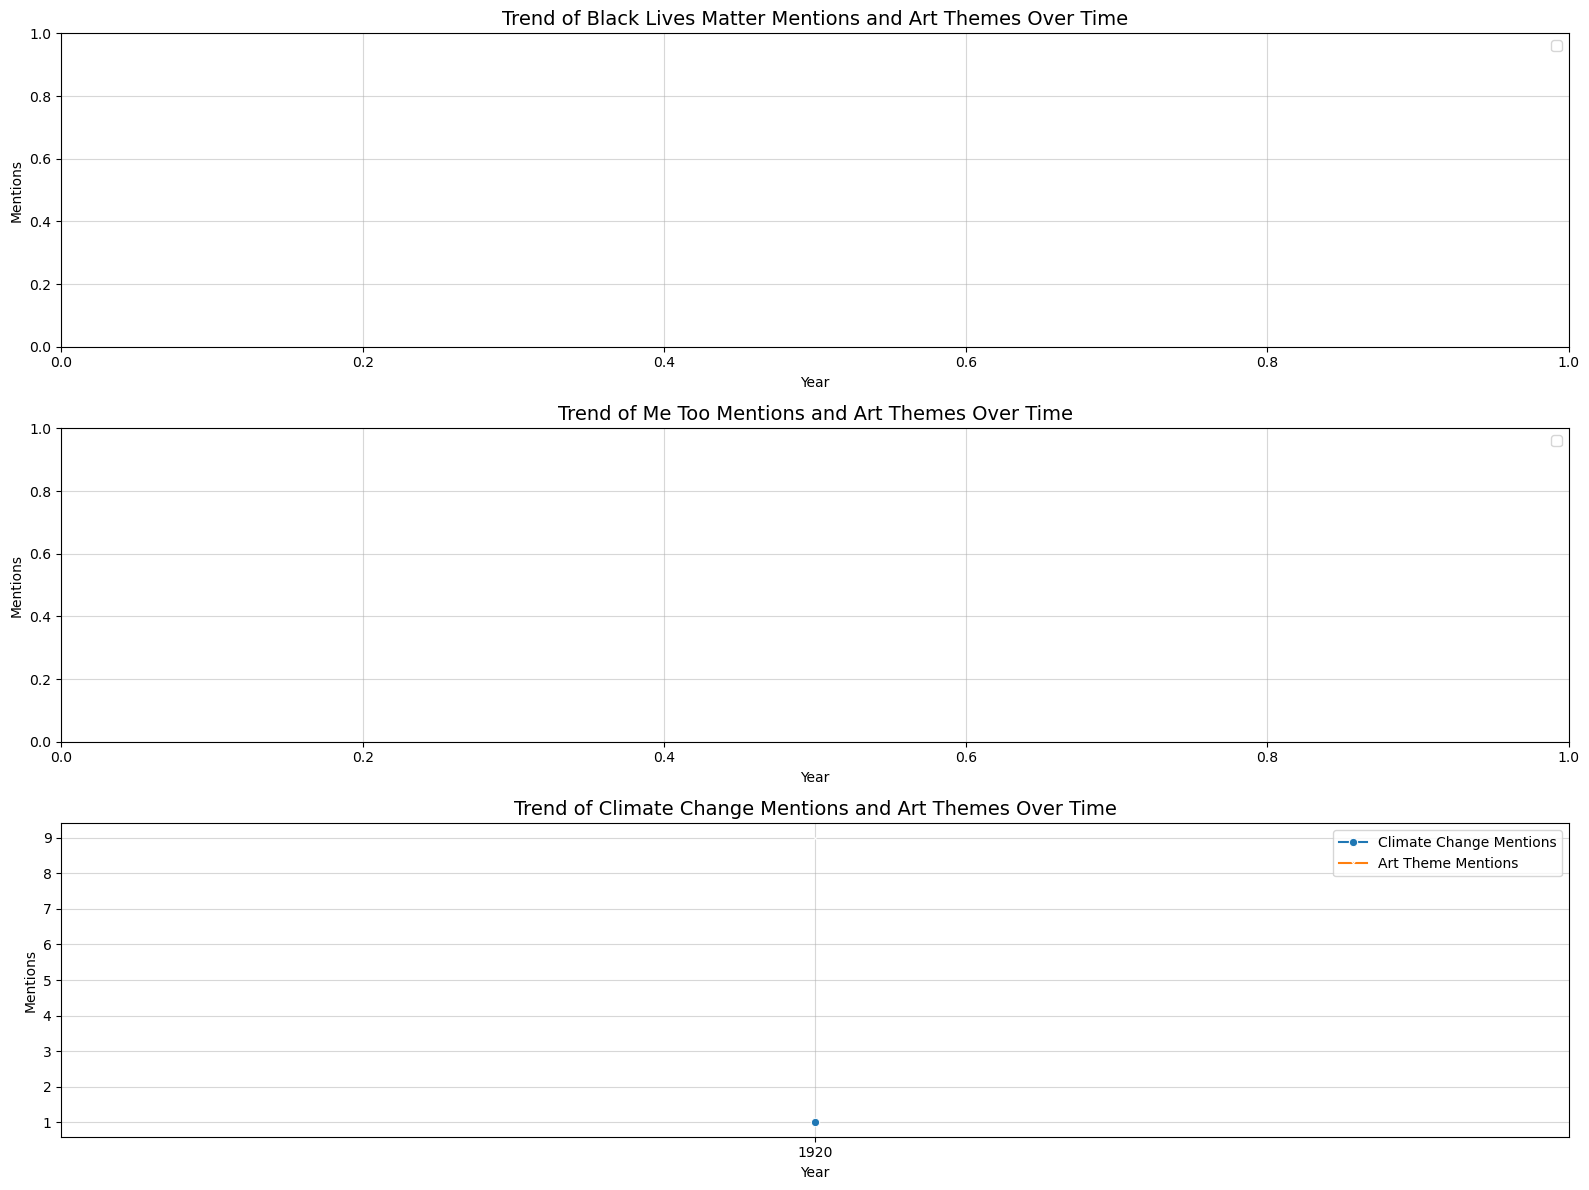

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
db_path = '../data_amelia/processed/social_movements.db'
conn = sqlite3.connect(db_path)

# Predefined keywords for social movements
keywords = {
    'Black Lives Matter': ['blm', 'black-lives-matter'],
    'Me Too': ['me-too', 'metoo', 'me-too-movement'],
    'Climate Change': ['climate-change', 'global-warming'],
}

# Query social movement data
movement_data = {}
for movement, terms in keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions, 
        AVG(GoldsteinScale) AS AvgGoldstein, 
        AVG(AvgTone) AS AvgTone
    FROM SocialMovements
    WHERE {term_conditions}
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)

# Query art themes data
art_query = """
SELECT 
    SUBSTR(ProductionYear, 1, 4) AS Year, 
    Topics
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL;
"""
art_data = pd.read_sql_query(art_query, conn)

# Process art themes
art_data['Topics'] = art_data['Topics'].fillna('').str.lower()
art_themes = art_data['Topics'].str.split(', ').explode().value_counts()
top_themes = art_themes.index[:10]  # Select top 10 themes for simplicity

# Extract yearly theme counts
yearly_theme_counts = pd.DataFrame([
    {'Year': year, 'Theme': theme, 'Count': count}
    for (year, theme), count in art_data.groupby(['Year', 'Topics']).size().items()
    if theme in top_themes
])


# Function to calculate top themes per decade
def top_themes_per_decade(yearly_theme_counts):
    yearly_theme_counts['Decade'] = (yearly_theme_counts['Year'].astype(int) // 10) * 10
    decade_theme_counts = yearly_theme_counts.groupby(['Decade', 'Theme'])['Count'].sum().reset_index()
    decade_theme_counts['Rank'] = decade_theme_counts.groupby('Decade')['Count'].rank(ascending=False, method='first')
    return decade_theme_counts[decade_theme_counts['Rank'] <= 3]

# Identify top themes per decade
top_themes_data = top_themes_per_decade(yearly_theme_counts)

# Merge social movement and art theme data
merged_data = {}
for movement, movement_df in movement_data.items():
    merged = pd.merge(
        movement_df,
        yearly_theme_counts.groupby('Year').sum().reset_index(),
        on='Year',
        how='inner'
    )
    merged_data[movement] = merged

# Analyze correlations
correlations = {}
for movement, merged_df in merged_data.items():
    corr = merged_df['TotalMentions'].corr(merged_df['Count'])
    correlations[movement] = corr
    print(f"Correlation between {movement} and art themes: {corr:.2f}")

# Visualize data
plt.figure(figsize=(16, 12))
for i, (movement, merged_df) in enumerate(merged_data.items(), start=1):
    plt.subplot(3, 1, i)
    sns.lineplot(x=merged_df['Year'], y=merged_df['TotalMentions'], label=f"{movement} Mentions", marker='o')
    sns.lineplot(x=merged_df['Year'], y=merged_df['Count'], label="Art Theme Mentions", marker='x')
    plt.title(f"Trend of {movement} Mentions and Art Themes Over Time", fontsize=14)
    plt.xlabel("Year")
    plt.ylabel("Mentions")
    plt.legend()
    plt.grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Save results for inspection
for movement, merged_df in merged_data.items():
    merged_df.to_csv(f"{movement.replace(' ', '_').lower()}_correlation.csv", index=False)



In [5]:
for movement, terms in keywords.items():
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE {" OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])}
    GROUP BY Year
    ORDER BY Year;
    """
    df = pd.read_sql_query(query, conn)
    print(f"{movement}:")
    print(df)


Black Lives Matter:
   Year  TotalMentions
0  2014             18
1  2015            126
2  2016            142
3  2017             41
4  2018             21
5  2019             27
6  2020            532
7  2021            110
8  2022             18
9  2023             55
Me Too:
   Year  TotalMentions
0  2017              1
1  2018             12
2  2019              3
3  2020              2
Climate Change:
    Year  TotalMentions
0   1920              1
1   2014             13
2   2015             15
3   2016              5
4   2017             29
5   2018             28
6   2019            144
7   2020             33
8   2021             19
9   2022             14
10  2023             27


<Figure size 1200x800 with 0 Axes>

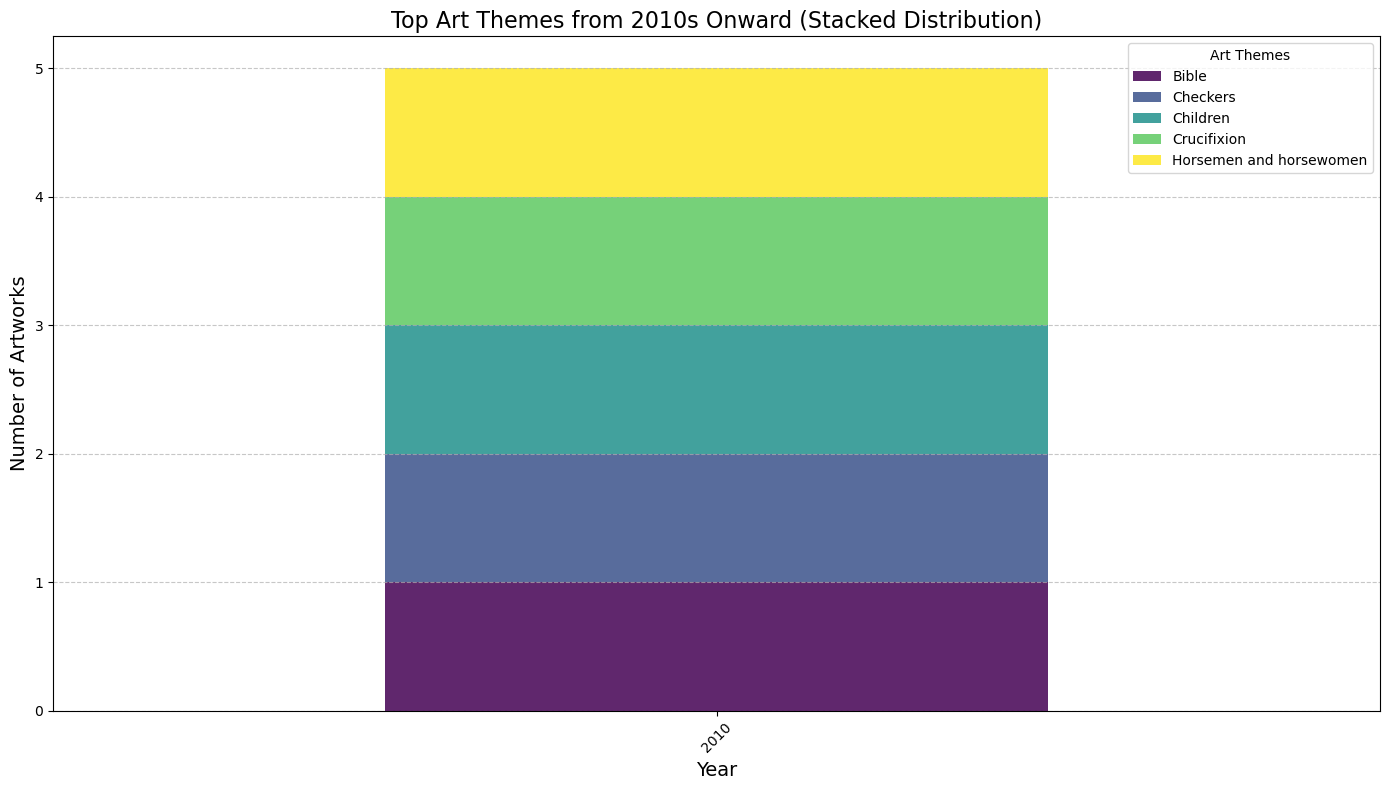

In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
db_path = '../data_amelia/processed/social_movements.db'  # Update this with your database path
conn = sqlite3.connect(db_path)

# Query to fetch data from Smithsonian (2010s onward)
query = """
SELECT 
    CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) AS Year, 
    Topics AS Theme
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) >= 2010;
"""
art_data = pd.read_sql_query(query, conn)

# Split the themes into individual rows (comma-separated values)
art_data['Theme'] = art_data['Theme'].str.split(", ")
art_data = art_data.explode('Theme')

# Group data to get yearly theme counts
yearly_theme_counts = (
    art_data.groupby(['Year', 'Theme'])
    .size()
    .reset_index(name='Count')
)

# Find the top themes from the 2010s onward
top_themes = (
    yearly_theme_counts.groupby('Theme')['Count']
    .sum()
    .nlargest(5)  # Top 5 themes
    .index
)

# Filter for top themes only
filtered_data = yearly_theme_counts[yearly_theme_counts['Theme'].isin(top_themes)]

# Pivot the data for stacked bar chart format
pivot_data = filtered_data.pivot(index='Year', columns='Theme', values='Count').fillna(0)

# Create a stacked bar chart
plt.figure(figsize=(12, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8), alpha=0.85)

# Add chart labels
plt.title('Top Art Themes from 2010s Onward (Stacked Distribution)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Artworks', fontsize=14)
plt.legend(title="Art Themes", fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Close database connection
conn.close()


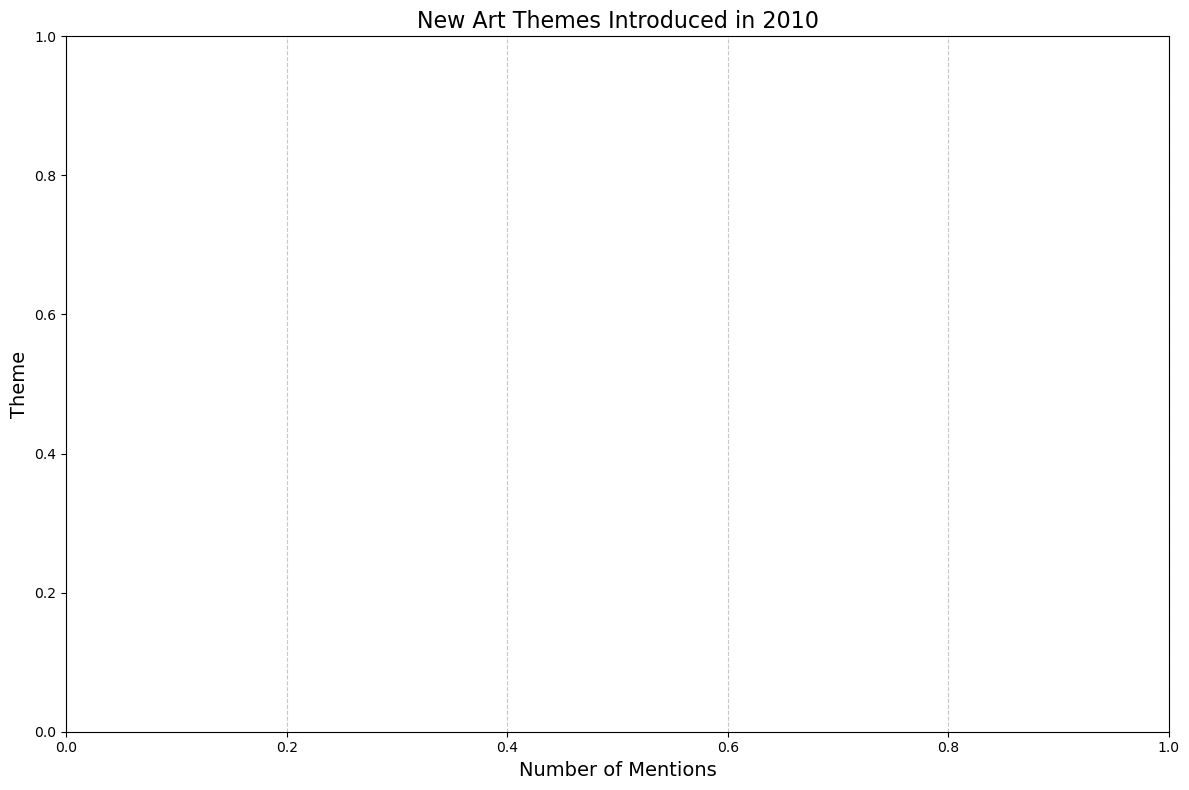

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
db_path = '../data_amelia/processed/social_movements.db'  # Update this with your database path
conn = sqlite3.connect(db_path)

# Query themes before 2010
query_before_2010 = """
SELECT 
    Topics AS Theme
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) < 2010;
"""
themes_before_2010 = pd.read_sql_query(query_before_2010, conn)
themes_before_2010['Theme'] = themes_before_2010['Theme'].str.split(", ")
themes_before_2010 = themes_before_2010.explode('Theme')
unique_themes_before_2010 = set(themes_before_2010['Theme'].dropna().unique())

# Query themes in 2010
query_2010 = """
SELECT 
    Topics AS Theme
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(SUBSTR(ProductionYear, 1, 4) AS INTEGER) = 2010;
"""
themes_2010 = pd.read_sql_query(query_2010, conn)
themes_2010['Theme'] = themes_2010['Theme'].str.split(", ")
themes_2010 = themes_2010.explode('Theme')
unique_themes_2010 = set(themes_2010['Theme'].dropna().unique())

# Find new themes in 2010
new_themes_2010 = unique_themes_2010 - unique_themes_before_2010

# Count occurrences of new themes in 2010
new_themes_2010_counts = (
    themes_2010[themes_2010['Theme'].isin(new_themes_2010)]
    .groupby('Theme')
    .size()
    .reset_index(name='Count')
)

# Sort by count for better visualization
new_themes_2010_counts = new_themes_2010_counts.sort_values(by='Count', ascending=False)

# Visualize the new themes
plt.figure(figsize=(12, 8))
sns.barplot(
    data=new_themes_2010_counts,
    x='Count',
    y='Theme',
    palette='viridis',
    alpha=0.9
)

# Add chart labels
plt.title('New Art Themes Introduced in 2010', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=14)
plt.ylabel('Theme', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Close database connection
conn.close()
